/home/matti/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


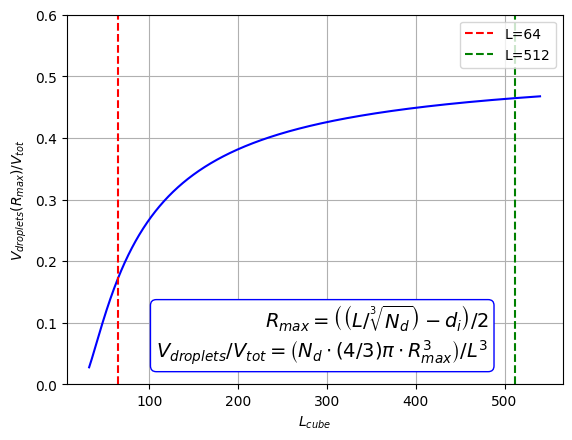

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# volume sfere / volume cubo tot
C = np.pi*4.0/3.0
interf = 2.5
n=64

def vol_ratio(R):
    return n*C*R**3 / (dim**3)

# volume n sfere a R_max / volume cubo tot
def max_vol_ratio(L):
    rmax = L/(2*np.cbrt(n)) - interf
    return n*C*rmax**3 / (L**3)

# questo e' per vedere un singolo caso: come varia il volume ratio cambiando il raggio delle sfere?
# dim=512
# Rmax=dim/(2*np.cbrt(n))-interf
# start = 20
# end = 80
# r = np.linspace(start,end,1000)
# _ = plt.figure(1)
# _ = plt.plot(r,vol_ratio(r),"blue")
# _ = plt.hlines(vol_ratio(Rmax), start, end, "red", "--")
# _ = plt.vlines(Rmax, 0, 1, "green", "--")
# _ = plt.xlabel(r"$R_{droplets}$")
# _ = plt.ylabel(r"$V_{droplets}/V_{tot}$")
# _ = plt.grid()
# _ = plt.ylim([0,1.0])
# _ = plt.title(r"$L_{cube}=$%d, $n_{droplets}$=%d"%(dim,n))

# questo invece mostra il max volume ratio (da R_max) per ogni possibile L_cube
start = 32
end = 540
dims = np.linspace(start,end,1000)
_ = plt.figure(2)
_ = plt.plot(dims,max_vol_ratio(dims), "blue")
_ = plt.vlines(64, 0, 0.6, "red", "--", label="L=64" )
_ = plt.vlines(512, 0, 0.6, "green", "--", label="L=512" )
_ = plt.xlabel(r"$L_{cube}$")
_ = plt.ylabel(r"$V_{droplets}(R_{max})/V_{tot}$")
_ = plt.grid()
_ = plt.ylim([0,0.6])
_ = plt.legend()
equation = r"$R_{max} = \left(\left(L / \sqrt[3]{N_d}\right) - d_i\right) / 2$" + "\n" + r"$V_{droplets}/V_{tot} = \left(N_d\cdot (4/3)\pi\cdot R_{max}^3\right)/L^3$"
box = dict(facecolor='white', edgecolor='blue', boxstyle='round,pad=0.3')
_ = plt.text(0.85, 0.05, equation, verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=14, color='black', bbox=box)

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

LOG_DISTRIB = 1;

#direc = "/home/matti/DATA/Mayonese/staggered_run_halfZ_doubleX/"; Nx=1024; Ny=512; Nz=256; start_move = 40000; dt=1000
#direc = "/home/matti/DATA/Mayonese/staggered_run_halfZ/"; Nx=512; Ny=512; Nz=256; start_move = 40000; dt=1000
# direc = "/home/matti/DATA/Mayonese/staggered_run/"; Nx=512; Ny=512; Nz=512; start_move = 30000; dt=500
direc = "/home/matti/DATA/Mayonese/staggered_run_1.5Z/"; Nx=512; Ny=512; Nz=768; start_move = 30000; dt=1000

bool_direc = direc!="/home/matti/DATA/Mayonese/staggered_run/"
bool_direc1024 = direc=="/home/matti/DATA/Mayonese/staggered_run_halfZ_doubleX/"

def find_push(f):
    change_indices = np.where(np.diff(f) != 0)[0] + 1
    segment_indices = np.concatenate(([0], change_indices, [len(f)]))
    result = []
    for i in range(len(segment_indices) - 1):
        value = f[segment_indices[i]]
        start_idx = segment_indices[i] - 1
        end_idx = segment_indices[i + 1] -2
        result.append([value, start_idx, end_idx+2])
    result = np.array(result)
    result[result<0] = 0
    return result
name  = "output.csv"
head  = np.genfromtxt(direc+name, delimiter=',\t', dtype=str,   max_rows=1)
A     = np.genfromtxt(direc+name, delimiter=',\t', dtype=float, skip_header=True)
ps    = find_push(A[:, 3])
print(f"header = {head}")
print(f"pushing factor = {ps}")

name  = "avgz.out"
avgz  = np.loadtxt(direc+name)
first_out_shear = int(start_move / dt)
number_out = int(A[-1,0]/dt)
print(f"number outputs : {number_out}")


# primo e secondo elemento: step e number_droplets
# terzo e quarto elemento: avarage volume e total volume [non per il file posvel]
# il resto sono vol e surf delle droplets
def read_nonunif_col(f,bool_twotwo,bool_vol):
    first_two_columns = []
    second_two_columns = []
    matrix_data = []
    with open(f, 'r') as file:
        for line in file:
            elements = line.split()
            if bool_twotwo:
                first_two_columns.append([int(elements[0]), int(elements[1])])
                second_two_columns.append([float(elements[2]), float(elements[3])]) 
                data = list(map(float, elements[4:]))
            else:
                first_two_columns.append([int(elements[0]), int(elements[1])])
                data = list(map(float, elements[2:]))
            matrix_data.append(data)
    max_length = max(len(row) for row in matrix_data)
    matrix_data_padded = np.array([row + [0] * (max_length - len(row)) for row in matrix_data])
    if bool_twotwo and bool_vol:
        matrix_data_padded = ((3.0/(4.0*np.pi))*matrix_data_padded)**(1.0/3.0)# from volume to radius
        second_two_columns = ((3.0/(4.0*np.pi))*np.array(second_two_columns))**(1.0/3.0)
    return np.array(first_two_columns).T, matrix_data_padded, np.array(second_two_columns).T
def binning(d, info, b, bin_type):
    max_drop_idx = np.argmax(info[1,:])
    max_d = max(d[max_drop_idx,:])+1; #max_d = ;
    min_d = min(d[max_drop_idx,:])-1; #min_d = 1e5;
    if   bin_type=='log' : bins = np.logspace(np.log10(min_d), np.log10(max_d), num=b)
    elif bin_type=='lin' : bins = np.linspace(min_d, max_d, num=b)
    else : print('choose a binning type: log or lin')
    all_count = []; all_bin_edges = []; all_bin_centers = []
    size = len(d[:,0])
    for i in range(size):
        count, bin_edges = np.histogram(d[i,:], bins=bins)
        all_count.append(count); all_bin_edges.append(bin_edges)
        all_bin_centers.append(np.array([(all_bin_edges[i][j]+all_bin_edges[i][j+1])*0.5 for j in range(b-1)]))
    return np.array(all_count), np.array(all_bin_edges), np.array(all_bin_centers)
name = "droplets_volume_rho1.dat"
step_e_num, d_vol, avg_e_tot_vol = read_nonunif_col(direc+name, 1, 1)
name = "droplets_surface_rho1.dat"
_         , d_sur, avg_e_tot_sur = read_nonunif_col(direc+name, 1, 0)
B = 30
count_vol, bin_edges_vol, bin_centers_vol = binning(d_vol, step_e_num, B, 'log')
count_sur, bin_edges_sur, bin_centers_sur = binning(d_sur, step_e_num, B, 'log')

# same as above, but for slabs along Z using the positions of CM for filters
if bool_direc:
    def read_posvel(f):
        step_e_num, d_posvel, _ = read_nonunif_col(f, 0, 0)
        d_pos = np.zeros((len(d_posvel[:,0]),int(len(d_posvel[0,:])/2)))
        d_vel = np.zeros_like(d_pos)
        for j in range(len(d_posvel[:,0])):
            d_pos[j,:] = np.array([d_posvel[j,i] for i in range(len(d_posvel[j,:])) if i % 6 <  3])
            d_vel[j,:] = np.array([d_posvel[j,i] for i in range(len(d_posvel[j,:])) if i % 6 >= 3])
        return d_pos, d_vel
    name = "droplets_posvel_rho1.dat"
    d_pos, d_vel = read_posvel(direc+name)
    idx_sz = 0; Nstepsz = 2; idx_ez = Nz; stepz = int(Nz/Nstepsz)
    idx_sy = 0; Nstepsy = 4; idx_ey = Ny; stepy = int(Ny/Nstepsy)
    #binning filtered by positions along Z
    count_vol_Zslabs=[]; bin_edges_vol_Zslabs=[]; bin_centers_vol_Zslabs=[]
    z = d_pos[:,2::3]
    if 0:
        for i in range(idx_sz,idx_ez,stepz):
            maskz = (z>i) & (z<i+stepz)
            # print(maskz);
            # print(d_vol);
            # print(d_vol[maskz]);
            a, b, c = binning(d_vol[maskz], step_e_num, B, 'log')
            count_vol_Zslabs.append(a)
            bin_edges_vol_Zslabs.append(b)
            bin_centers_vol_Zslabs.append(c)
        # count_vol_Zslabs = np.array(count_vol_Zslabs)
        # bin_edges_vol_Zslabs = np.array(bin_edges_vol_Zslabs)
        # bin_centers_vol_Zslabs = np.array(bin_centers_vol_Zslabs)

    #print(count_vol_Zslabs);

    # for i in range(0, len(d_pos[0,:]), 3):
    #     print(' '.join(map(str, d_pos[0,i:i+3])))

/home/matti/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/tmp/ipykernel_21313/2789923875.py:69: RuntimeWarning: invalid value encountered in log10
  if   bin_type=='log' : bins = np.logspace(np.log10(min_d), np.log10(max_d), num=b)


header = ['Step' 'N_Drop' 'Vd/Vt' 'Push']
pushing factor = [[1.00e-04 0.00e+00 3.00e+00]
 [0.00e+00 2.00e+00 2.00e+01]
 [2.00e-05 1.90e+01 2.40e+01]
 [0.00e+00 2.30e+01 3.00e+02]
 [7.00e-06 2.99e+02 3.22e+02]
 [0.00e+00 3.21e+02 6.00e+02]]
number outputs : 600


RR = [ 29000 143000 257000 371000 485000 599000]
RR = [ 29000 143000 257000 371000 485000 599000]
RR = [     0 119000 239000 359000 479000 599000]


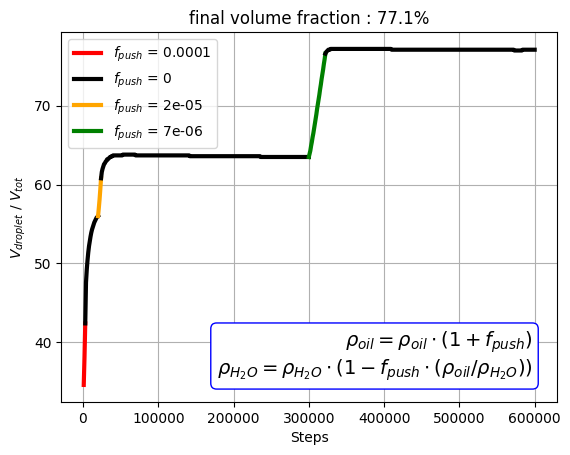

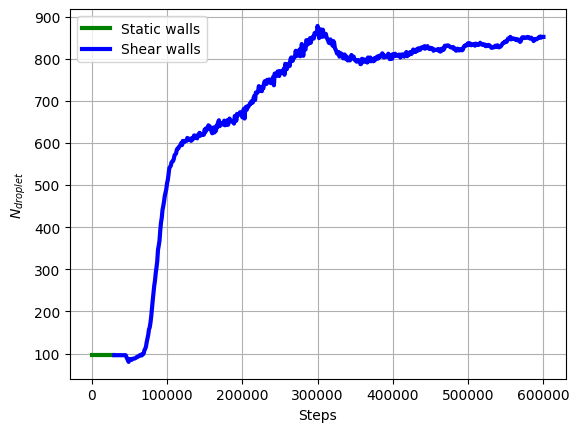

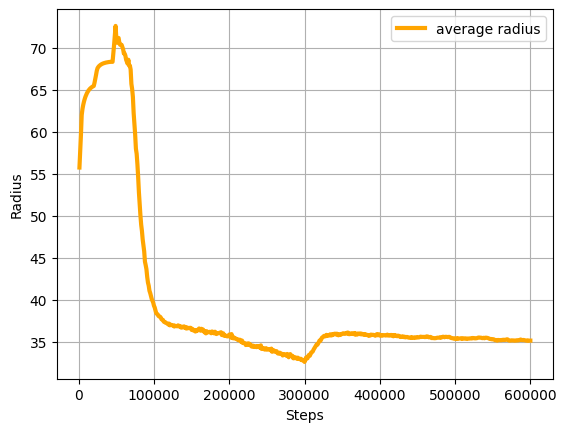

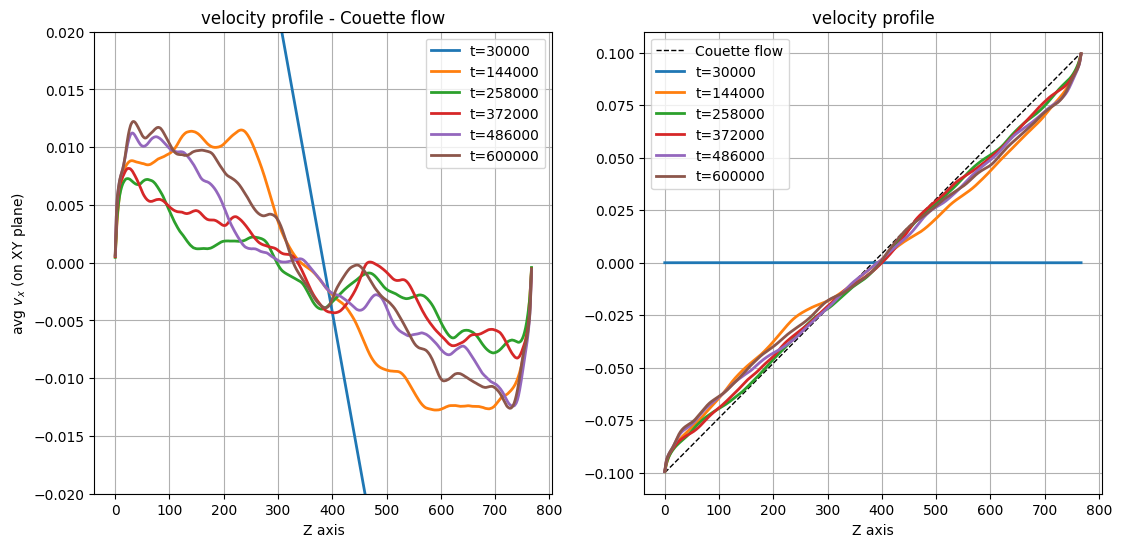

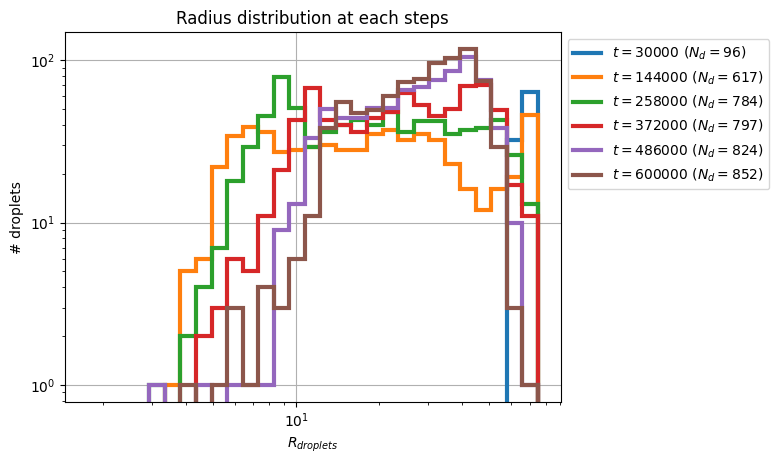

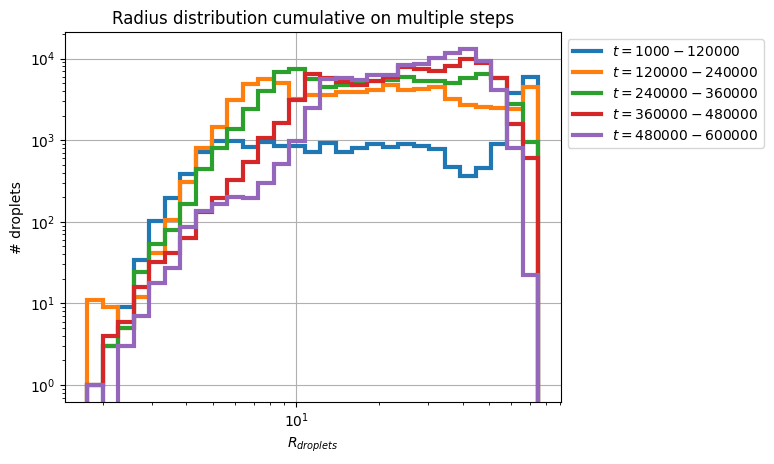

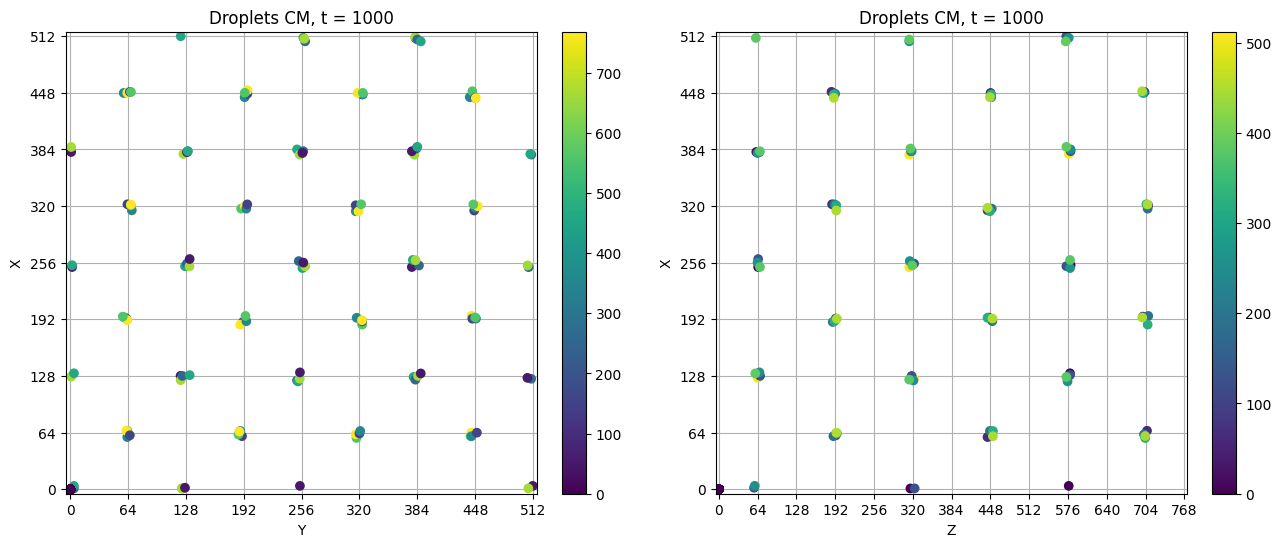

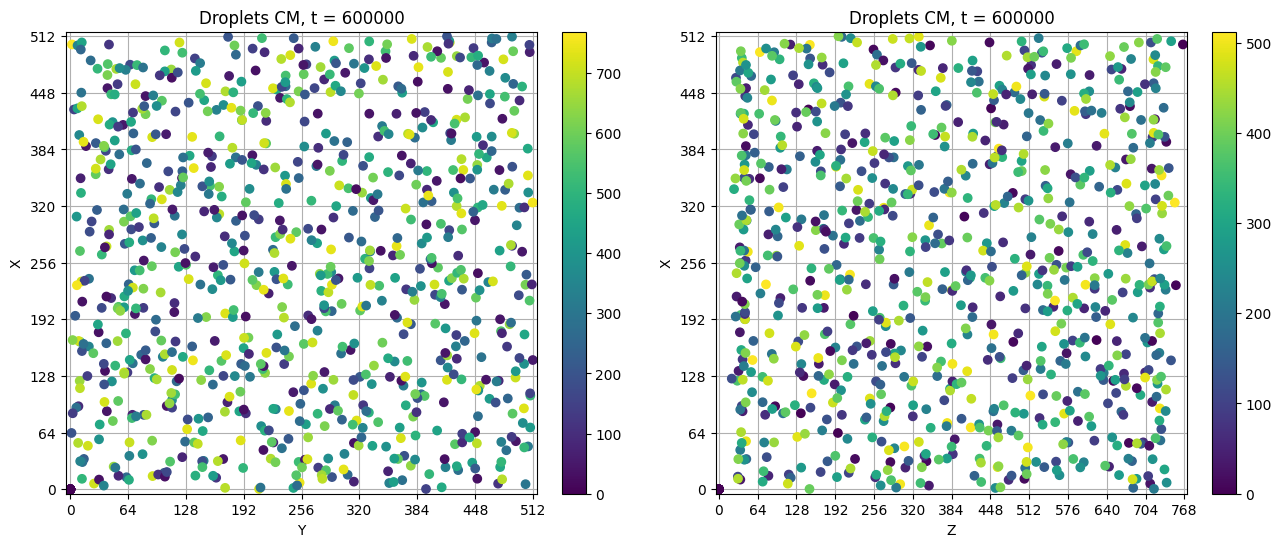

In [4]:
LIM = number_out * dt
#LIM = 250000

final_out = int(LIM/dt) -1

SAVE = 1
save_dir = '/home/matti/Pictures/images/'

#evolution of volume fraction
if not bool_direc1024:
    def pp(f, p, col, L=True):
        idx_s = int(p[1])
        idx_e = int(p[2])
        if L: lab = '$f_{push}$ = %1.1g'%(p[0]); 
        else: lab = ""
        _ = plt.plot(f[idx_s:idx_e,0], f[idx_s:idx_e,2], color=col, linewidth=3, label=lab)
    f1 = plt.figure(1)
    idx=0
    pp(A, ps[idx,:], "red"); idx+=1
    pp(A, ps[idx,:], "black"); idx+=1
    pp(A, ps[idx,:], "orange"); idx+=1
    pp(A, ps[idx,:], "black", False); idx+=1
    pp(A, ps[idx,:], "green"); idx+=1
    # pp(A, ps[idx,:], "lime"); idx+=1
    pp(A, ps[idx,:], "black", False); idx+=1
    _ = plt.rc('axes', axisbelow=True)
    _ = plt.grid()
    _ = plt.xlabel("Steps")
    _ = plt.ylabel("$V_{droplet}$ / $V_{tot}$")
    _ = plt.title(r"final volume fraction : %1.1f%%"%(A[final_out,2]))
    # _ = plt.xlim(0,15000)
    equation = r"$\rho_{oil} = \rho_{oil}\cdot(1+f_{push})$" + "\n" + r"$\rho_{H_2O} = \rho_{H_2O}\cdot(1-f_{push}\cdot(\rho_{oil}/\rho_{H_2O}))$"
    box = dict(facecolor='white', edgecolor='blue', boxstyle='round,pad=0.3')
    #_ = plt.text(0.05, 0.80, equation, verticalalignment='bottom', horizontalalignment='left', transform=plt.gca().transAxes, fontsize=14, color='black', bbox=box)
    _ = plt.text(0.95, 0.05, equation, verticalalignment='bottom', horizontalalignment='right', transform=plt.gca().transAxes, fontsize=14, color='black', bbox=box)
    _ = plt.legend()
    if SAVE:
        _ = plt.savefig(save_dir+"v_frac.png", bbox_inches='tight', dpi=300, format='png')


#evolution of total number of droplets
if not bool_direc1024:
    def ppN(f, start, stop, name, col):
        mask = ( (f[:,0]<=stop) & (f[:,0]>=start) )
        _ = plt.plot(f[mask,0], f[mask,1], color=col, linewidth=3, label=name)
    def plot_lin_fit(f, start, stop, name, col):
        mask = ( (f[:,0]<=stop) & (f[:,0]>=start) )
        m, q = np.polyfit(f[mask,0],f[mask,1],1)
        lab = " (m=%1.6f)"%(m); labtot = " (m=%1.6f, q=%1.1f)"%(m,q)
        _ = plt.plot(f[mask,0], m*f[mask,0]+q+50, color=col, linewidth=2, linestyle="--", label=name+lab)
        return m
    f2 = plt.figure(2)
    end = A[final_out,0]
    ppN(A, 0, start_move, "Static walls", "green")
    if start_move<LIM:
        ppN(A, start_move, end, "Shear walls", "blue")
    FITS=0
    if FITS and start_move<LIM:
        m = np.zeros((4))
        m[0] = plot_lin_fit(A,70000,95000,"fit$_1$","red")
        m[1] = plot_lin_fit(A,95000,151000,"fit$_2$","orange")
        m[2] = plot_lin_fit(A,151000,200000,"fit$_3$","magenta")
        m[3] = plot_lin_fit(A,211000,350000,"fit$_4$","lime")
        print(f"m scale : {m/m[0]}")
    _ = plt.plot()
    _ = plt.rc('axes', axisbelow=True)
    _ = plt.legend()#loc='upper left', bbox_to_anchor=(1, 1))
    _ = plt.grid()
    _ = plt.xlabel("Steps")
    _ = plt.ylabel("$N_{droplet}$")
    # _ = plt.xlim(20000,80000)
    # _ = plt.ylim(0,400)
else:
    f2 = plt.figure(2)
    _ = plt.plot(step_e_num[0,:], step_e_num[1,:], color="blue", linewidth=3, label='Number of droplets')
    _ = plt.grid()
    _ = plt.legend()
    _ = plt.xlabel("Steps")
    _ = plt.ylabel("$N_{droplet}$")
if SAVE:
    _ = plt.savefig(save_dir+"N_drop.png", bbox_inches='tight', dpi=300, format='png')

_ = plt.figure(100)
_ = plt.plot(step_e_num[0,:],avg_e_tot_vol[0,:], color="orange", linewidth=3, label='average radius')
_ = plt.xlabel('Steps')
_ = plt.ylabel('Radius')
_ = plt.rc('axes', axisbelow=True)
_ = plt.legend()
_ = plt.grid()
if SAVE:
    _ = plt.savefig(save_dir+"R_ava.png", bbox_inches='tight', dpi=300, format='png')


if (first_out_shear<final_out):
    # velocity_x profile along Z
    number_lines = 6;
    RR = np.linspace(first_out_shear-1,(LIM/dt)-1,number_lines).astype(int); print(f"RR = {RR*dt}")
    f3 = plt.figure(3,  figsize=[13,6])
    gs3 = f3.add_gridspec(1,2)
    axs3 = gs3.subplots()
    l = np.linspace(0,Nz-1,Nz)
    lv = np.linspace(-0.1,+0.1,Nz)
    #_ = plt.plot(l,lv,color='black', linestyle='--',linewidth=1, label="Couette flow")
    for i in RR:
        _ = axs3[0].plot(avgz[i,:] - lv, linewidth=2, label="t=%d"%((i+1)*dt))
    _ = axs3[0].legend()
    _ = axs3[0].grid()
    #_ = axs3[0].set_ylim([-0.012,+0.012])
    _ = axs3[0].set_ylim([-0.02,+0.02])
    _ = axs3[0].set_title("velocity profile - Couette flow")
    _ = axs3[0].set_xlabel("Z axis")
    _ = axs3[0].set_ylabel("avg $v_x$ (on XY plane)")
    _ = axs3[1].plot(l,lv,color='black', linestyle='--',linewidth=1, label="Couette flow")
    for i in RR:
        _ = axs3[1].plot(avgz[i,:], linewidth=2, label="t=%d"%((i+1)*dt))
    _ = axs3[1].legend()
    _ = axs3[1].grid()
    _ = axs3[1].set_title("velocity profile")
    _ = axs3[1].set_xlabel("Z axis")
    if SAVE:
        _ = plt.savefig(save_dir+"v_prof.png", bbox_inches='tight', dpi=300, format='png')


    # distribution of droplets volume at each steps
    number_lines = 6;
    RR = np.linspace(first_out_shear-1,(LIM/dt)-1,number_lines).astype(int); print(f"RR = {RR*dt}")
    #max_pick = np.max(count_vol)
    max_pick = 1
    f4 = plt.figure(4)
    for i in RR:
        _ = plt.stairs(count_vol[i,:]/max_pick, bin_edges_vol[i,:], linewidth=3, label="$t=%d$ $(N_{d}=%d)$"%(step_e_num[0,i],step_e_num[1,i]))
        #_ = plt.plot(bin_centers_vol[i,:], count_vol[i,:]/max_pick, linewidth=2, label="$t=%d$ $(N_{d}=%d)$"%(step_e_num[0,i],step_e_num[1,i]))
    if LOG_DISTRIB :
        _ = plt.yscale('log')
    _ = plt.xscale('log')
    _ = plt.xlabel('$R_{droplets}$')
    _ = plt.ylabel('# droplets');# (normalized to max)')
    _ = plt.rc('axes', axisbelow=True)
    _ = plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    _ = plt.grid(True)
    _ = plt.title('Radius distribution at each steps')
    if SAVE:
        _ = plt.savefig(save_dir+"R_distr.png", bbox_inches='tight', dpi=300, format='png')
    
    
    # distribution of droplets volume cumulative on multiple steps
    number_lines = 6;
    RR = np.linspace(0,(LIM/dt)-1,number_lines).astype(int); print(f"RR = {RR*dt}")
    f5 = plt.figure(5)
    for i in range(len(RR)-1):
        i_s = RR[i]
        i_e = RR[i+1]
        norm=1/((i_e-i_s)*max_pick)
        norm=1
        _ = plt.stairs(np.sum(count_vol[i_s:i_e,:], axis=0)*norm, bin_edges_vol[i_e,:], linewidth=3, label="$t=%d-%d$"%(step_e_num[0,i_s],step_e_num[0,i_e]))
        #_ = plt.plot(bin_centers_vol[i_e,:], np.sum(count_vol[i_s:i_e,:], axis=0)*norm, linewidth=2, label="$t=%d-%d$"%(step_e_num[0,i_s],step_e_num[0,i_e]))
    # i_s = int(500000/dt); i_e = int(599500/dt); norm=1/((i_e-i_s)*max_pick)
    # _ = plt.stairs(np.sum(count_vol[i_s:i_e,:], axis=0)*norm, bin_edges_vol[i_e,:], color='black', linestyle='--', linewidth=3, label="$t=%d-%d$"%(step_e_num[0,i_s],step_e_num[0,i_e]))
    if LOG_DISTRIB :
        _ = plt.yscale('log')
    _ = plt.xscale('log')
    _ = plt.xlabel('$R_{droplets}$')
    # _ = plt.ylabel('# droplets cumulative (normalized to max)')
    _ = plt.ylabel('# droplets')
    _ = plt.rc('axes', axisbelow=True)
    _ = plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    _ = plt.grid(True)
    _ = plt.title('Radius distribution cumulative on multiple steps')
    if SAVE:
        _ = plt.savefig(save_dir+"R_distr_cumulative.png", bbox_inches='tight', dpi=300, format='png')


if(bool_direc):
    # position of drolpets CM visualizzation
    def plot_cm_pos(time, d_pos, ifig):
        x = d_pos[time,0::3]
        y = d_pos[time,1::3]
        z = d_pos[time,2::3]
        ticks_x = [i for i in range(0,Nx+1,64)]
        ticks_y = [i for i in range(0,Ny+1,64)]
        ticks_z = [i for i in range(0,Nz+1,64)]
        f6 = plt.figure(ifig,  figsize=[13,6])
        gs6_1 = f6.add_gridspec(1,2,width_ratios=[1,0.05], wspace=0.1, left=0.05, right=0.45)#, hspace=0)
        axs6_1 = gs6_1.subplots()
        gs6_2 = f6.add_gridspec(1,2,width_ratios=[1,0.05], wspace=0.1, left=0.55, right=0.95)#, hspace=0)
        axs6_2 = gs6_2.subplots()
        # for i in range(idx_sz,idx_ez,stepz):
        #     maskz = (z>i) & (z<i+stepz)
        #     _ = axs6[0].scatter(y[maskz],x[maskz],label=r'z$\geq$%d and z<%d'%(i,i+stepz))
        # for i in range(idx_sy,idx_ey,stepy):
        #     masky = (y>i) & (y<i+stepy)
        #     _ = axs6[1].scatter(z[masky],x[masky],label=r'y$\geq$%d and y<%d'%(i,i+stepy))
        C1 = axs6_1[0].scatter(y,x,c=z)#,label=r'z$\geq$%d and z<%d'%(i,i+stepz))
        C2 = axs6_2[0].scatter(z,x,c=y)#,label=r'y$\geq$%d and y<%d'%(i,i+stepy))
        _ = matplotlib.colorbar.ColorbarBase(axs6_1[1], norm=matplotlib.colors.Normalize(vmin=0, vmax=Nz), cmap = C1.cmap)
        _ = matplotlib.colorbar.ColorbarBase(axs6_2[1], norm=matplotlib.colors.Normalize(vmin=0, vmax=Ny), cmap = C2.cmap)
        _ = axs6_1[0].set_xlabel('Y')
        _ = axs6_1[0].set_ylabel('X')
        _ = axs6_1[0].grid(True)
        _ = axs6_1[0].set_xlim(-5,Ny+5)
        _ = axs6_1[0].set_ylim(-5,Nx+5)
        _ = axs6_1[0].set_xticks(ticks_y)
        _ = axs6_1[0].set_yticks(ticks_x)
        _ = axs6_1[0].set_title("Droplets CM, t = %d"%(int((1+time)*dt)))
        _ = axs6_2[0].set_xlabel('Z')
        _ = axs6_2[0].set_ylabel('X')
        _ = axs6_2[0].grid(True)
        _ = axs6_2[0].set_xlim(-5,Nz+5)
        _ = axs6_2[0].set_ylim(-5,Nx+5)
        _ = axs6_2[0].set_xticks(ticks_z)
        _ = axs6_2[0].set_yticks(ticks_x)
        _ = axs6_2[0].set_title("Droplets CM, t = %d"%(int((1+time)*dt)))
    plot_cm_pos(0, d_pos, 7)
    plot_cm_pos(final_out, d_pos, 8)

    # distribution of droplets volume at a step for slabs along Z
    #max_pick = np.max(count_vol)
    # max_pick = 1
    # f4 = plt.figure(4)
    # for i in range(idx_sz,idx_ez,stepz):
    #     _ = plt.stairs(count_vol[i,:]/max_pick, bin_edges_vol[i,:], linewidth=3, label=r"(z$\geq$%d and z<%d) $(N_{d}=%d)$"%(i,i+stepz,step_e_num[1,i]))
    #     #_ = plt.plot(bin_centers_vol[i,:], count_vol[i,:]/max_pick, linewidth=2, label="$t=%d$ $(N_{d}=%d)$"%(step_e_num[0,i],step_e_num[1,i]))
    # _ = plt.title('time = %d'%(step_e_num[0,time]))
    # _ = plt.xscale('log')
    # _ = plt.xlabel('$R_{droplets}$')
    # _ = plt.ylabel('# droplets');# (normalized to max)')
    # _ = plt.rc('axes', axisbelow=True)
    # _ = plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    # _ = plt.grid(True)
    # if SAVE:
    #     _ = plt.savefig(save_dir+"R_distr.png", bbox_inches='tight', dpi=300, format='png')

R ava arithmetic
R256/R512 (300k) = 0.861812
R512/R768 (300k) = 0.792936
R256/R768 (300k) = 0.683362
R256/R512 (end ) = 0.970955
R512/R768 (end ) = 0.958849
R256/R768 (end ) = 0.930999
R ava D32
R256/R512 (300k) = 0.853242
R512/R768 (300k) = 0.732403
R256/R768 (300k) = 0.624917
R256/R512 (end ) = 1.29774
R512/R768 (end ) = 0.9628
R256/R768 (end ) = 1.24947
R ava D33
R256/R512 (300k) = 0.955994
R512/R768 (300k) = 0.736425
R256/R768 (300k) = 0.704018
R256/R512 (end ) = 1.6114
R512/R768 (end ) = 1.00501
R256/R768 (end ) = 1.61947


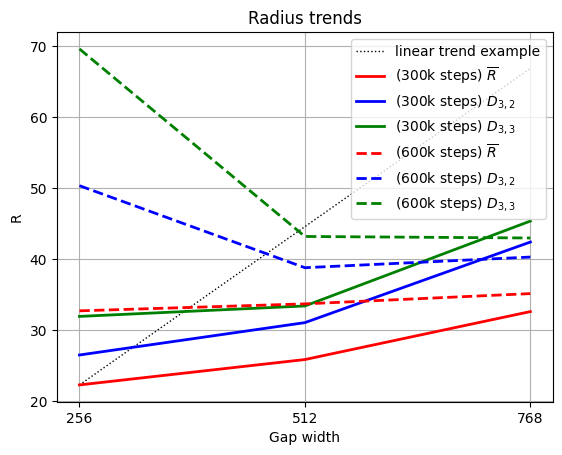

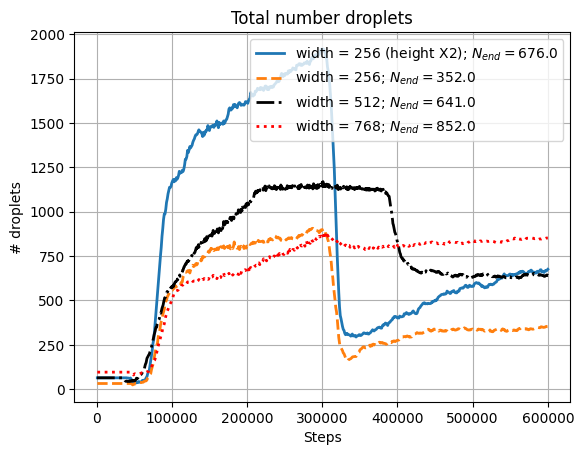

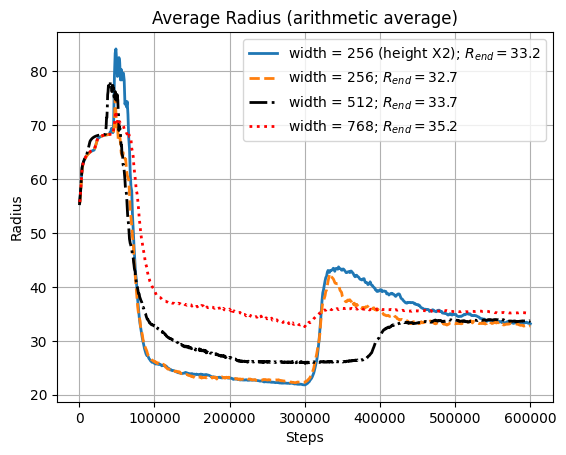

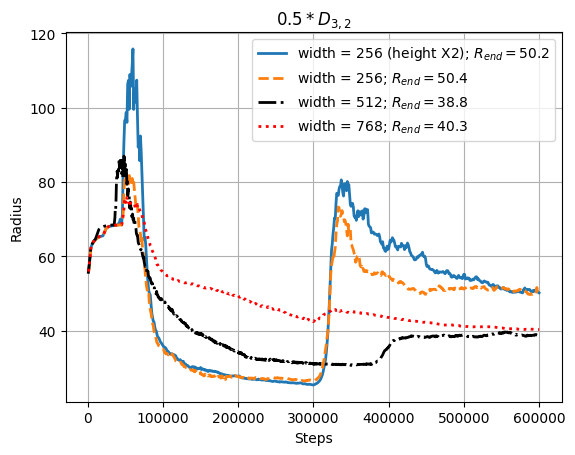

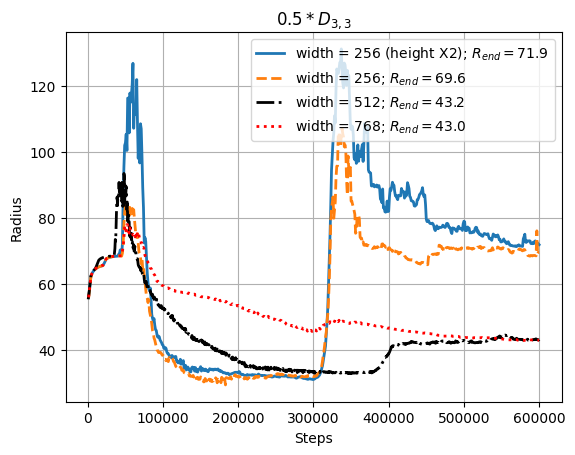

In [9]:
def comp_rad(V):
    return np.cbrt(3*V/(4*np.pi))

def compute_Rava_D32_D33(steps,V,F,RF):
    VF = 1e15
    if F: VF = 4*np.pi*(RF**3)/3
    Vava = np.array([np.mean(V[i], where=((V[i]>0)&(V[i]<VF))) for i in range(steps)])
    D = 2*comp_rad(V)
    if F: D[D>RF*2] = 0 # rimuovo colonne
    D32num   = np.array([np.sum(D[i]**3) for i in range(steps)])
    D32denum = np.array([np.sum(D[i]**2) for i in range(steps)])
    D[D==0] = 1 # cambio gli elementi nulli per non far sbroccare il logaritmo
    D33num   = np.array([np.sum(np.log(D[i])*D[i]**3) for i in range(steps)])
    D33denum = D32num
    # ritorno il Raggio con media aritmetica e il raggio (quindi *0.5) calcolato con D32 e D33
    return comp_rad(Vava), (0.5*D32num/D32denum), (0.5*np.exp(D33num/D33denum)) 

def comp_ratio(dt1, dt2, name, A, B, dtA, dtB):
    idxA = int( (dt1-dtA)/dtA )
    idxB = int( (dt2-dtB)/dtB )
    print("%s = %g"%(name, A[idxA]/B[idxB]))

direc256 = "/home/matti/DATA/Mayonese/staggered_run_halfZ/";# Nx=512; Ny=512; Nz=256
direc512 = "/home/matti/DATA/Mayonese/staggered_run/";# Nx=512; Ny=512; Nz=512
direc2561024 = "/home/matti/DATA/Mayonese/staggered_run_halfZ_doubleX/";# Nx=512; Ny=512; Nz=512
direc768 = "/home/matti/DATA/Mayonese/staggered_run_1.5Z/";# Nx=512; Ny=512; Nz=768

SAVE = 1;

FILTER = 0; 
RF = 80;

name = "droplets_volume_rho1.dat"
step_e_num512, d_vol512, avg_e_tot_vol512 = read_nonunif_col(direc512+name, 1, 0)
step_e_num256, d_vol256, avg_e_tot_vol256 = read_nonunif_col(direc256+name, 1, 0)
step_e_num2561024, d_vol2561024, avg_e_tot_vol2561024 = read_nonunif_col(direc2561024+name, 1, 0)
step_e_num768, d_vol768, avg_e_tot_vol768 = read_nonunif_col(direc768+name, 1, 0)

Rava_512, D32_512, D33_512 = compute_Rava_D32_D33(len(step_e_num512[0,:]), d_vol512, FILTER, RF)
Rava_256, D32_256, D33_256 = compute_Rava_D32_D33(len(step_e_num256[0,:]), d_vol256, FILTER, RF)
Rava_2561024, D32_2561024, D33_2561024 = compute_Rava_D32_D33(len(step_e_num2561024[0,:]), d_vol2561024, FILTER, RF)
Rava_768, D32_768, D33_768 = compute_Rava_D32_D33(len(step_e_num768[0,:]), d_vol768, FILTER, RF)

print("R ava arithmetic")
comp_ratio(300000,300000,"R256/R512 (300k)",Rava_256,Rava_512,1000,500)
comp_ratio(300000,300000,"R512/R768 (300k)",Rava_512,Rava_768,500,1000)
comp_ratio(300000,300000,"R256/R768 (300k)",Rava_256,Rava_768,1000,1000)
comp_ratio(600000,600000,"R256/R512 (end )",Rava_256,Rava_512,1000,500)
comp_ratio(600000,600000,"R512/R768 (end )",Rava_512,Rava_768,500,1000)
comp_ratio(600000,600000,"R256/R768 (end )",Rava_256,Rava_768,1000,1000)
print("R ava D32")
comp_ratio(300000,300000,"R256/R512 (300k)",D32_256,D32_512,1000,500)
comp_ratio(300000,300000,"R512/R768 (300k)",D32_512,D32_768,500,1000)
comp_ratio(300000,300000,"R256/R768 (300k)",D32_256,D32_768,1000,1000)
comp_ratio(600000,600000,"R256/R512 (end )",D32_256,D32_512,1000,500)
comp_ratio(600000,600000,"R512/R768 (end )",D32_512,D32_768,500,1000)
comp_ratio(600000,600000,"R256/R768 (end )",D32_256,D32_768,1000,1000)
print("R ava D33")
comp_ratio(300000,300000,"R256/R512 (300k)",D33_256,D33_512,1000,500)
comp_ratio(300000,300000,"R512/R768 (300k)",D33_512,D33_768,500,1000)
comp_ratio(300000,300000,"R256/R768 (300k)",D33_256,D33_768,1000,1000)
comp_ratio(600000,600000,"R256/R512 (end )",D33_256,D33_512,1000,500)
comp_ratio(600000,600000,"R512/R768 (end )",D33_512,D33_768,500,1000)
comp_ratio(600000,600000,"R256/R768 (end )",D33_256,D33_768,1000,1000)

Rw = np.array([256,512,768])
idx500  = int( (300000-500)/500 )
idx1000 = int( (300000-1000)/1000 )
lin_case = np.array([Rava_256[idx1000], Rava_256[idx1000]*2, Rava_256[idx1000]*3])
R_half = np.array([Rava_256[idx1000],Rava_512[idx500],Rava_768[idx1000]])
D32_half = np.array([D32_256[idx1000],D32_512[idx500],D32_768[idx1000]])
D33_half = np.array([D33_256[idx1000],D33_512[idx500],D33_768[idx1000]])
idx500  = int( (600000-500)/500 )
idx1000 = int( (600000-1000)/1000 )
R_end  = np.array([Rava_256[idx1000],Rava_512[idx500],Rava_768[idx1000]])
D32_end = np.array([D32_256[idx1000],D32_512[idx500],D32_768[idx1000]])
D33_end = np.array([D33_256[idx1000],D33_512[idx500],D33_768[idx1000]])

_ = plt.figure(182)
_ = plt.plot(Rw, lin_case, linewidth=1, linestyle=':',  color='black', label=r'linear trend example')
_ = plt.plot(Rw, R_half,   linewidth=2, linestyle='-',  color='red',   label=r'(300k steps) $\overline{R}$')
_ = plt.plot(Rw, D32_half, linewidth=2, linestyle='-',  color='blue',  label=r'(300k steps) $D_{3,2}$')
_ = plt.plot(Rw, D33_half, linewidth=2, linestyle='-',  color='green', label=r'(300k steps) $D_{3,3}$')
_ = plt.plot(Rw, R_end,    linewidth=2, linestyle='--', color='red',   label=r'(600k steps) $\overline{R}$')
_ = plt.plot(Rw, D32_end,  linewidth=2, linestyle='--', color='blue',  label=r'(600k steps) $D_{3,2}$')
_ = plt.plot(Rw, D33_end,  linewidth=2, linestyle='--', color='green', label=r'(600k steps) $D_{3,3}$')
_ = plt.xlabel('Gap width')
_ = plt.ylabel('R')
_ = plt.xticks(Rw)
_ = plt.rc('axes', axisbelow=True)
_ = plt.legend()
_ = plt.grid()
_ = plt.title('Radius trends')
if SAVE:
    _ = plt.savefig(save_dir+"R_trends.png", bbox_inches='tight', dpi=300, format='png')

if FILTER: labF = " [filter R>%d]"%RF
else: labF= ""

_ = plt.figure(99)
#_ = plt.plot(step_e_num512[0,:], step_e_num512[1,:], label=r'width = $512$')
_ = plt.plot(step_e_num2561024[0,:], step_e_num2561024[1,:], linewidth=2, label=r'width = $256$ (height X2); $N_{end}=$%1.1f'%step_e_num2561024[1,-1])
_ = plt.plot(step_e_num256[0,:], step_e_num256[1,:], linestyle='--', linewidth=2, label=r'width = $256$; $N_{end}=$%1.1f'%step_e_num256[1,-1])
_ = plt.plot(step_e_num512[0,:], step_e_num512[1,:], color='black', linestyle='-.', linewidth=2, label=r'width = $512$; $N_{end}=$%1.1f'%step_e_num512[1,-1])
_ = plt.plot(step_e_num768[0,:], step_e_num768[1,:], color='red', linestyle=':', linewidth=2, label=r'width = $768$; $N_{end}=$%1.1f'%step_e_num768[1,-1])
_ = plt.xlabel('Steps')
_ = plt.ylabel('# droplets')
_ = plt.rc('axes', axisbelow=True)
_ = plt.legend()
_ = plt.grid()
_ = plt.title('Total number droplets')
if SAVE:
    _ = plt.savefig(save_dir+"N_drop_comp.png", bbox_inches='tight', dpi=300, format='png')

_ = plt.figure(100)
#_ = plt.plot(step_e_num512[0,:], avg_e_tot_vol512[0,:], label=r'width = $512$')
_ = plt.plot(step_e_num2561024[0,:], Rava_2561024, linewidth=2, label=r'width = $256$ (height X2); $R_{end}=$%1.1f'%Rava_2561024[-1])
_ = plt.plot(step_e_num256[0,:], Rava_256, linestyle='--', linewidth=2, label=r'width = $256$; $R_{end}=$%1.1f'%Rava_256[-1])
_ = plt.plot(step_e_num512[0,:], Rava_512, color='black', linestyle='-.', linewidth=2, label=r'width = $512$; $R_{end}=$%1.1f'%Rava_512[-1])
_ = plt.plot(step_e_num768[0,:], Rava_768, color='red', linestyle=':', linewidth=2, label=r'width = $768$; $R_{end}=$%1.1f'%Rava_768[-1])
_ = plt.xlabel('Steps')
_ = plt.ylabel('Radius')
_ = plt.rc('axes', axisbelow=True)
_ = plt.legend()
_ = plt.grid()
_ = plt.title('Average Radius (arithmetic average)'+labF)
if SAVE:
    _ = plt.savefig(save_dir+"R_ava_comp.png", bbox_inches='tight', dpi=300, format='png')

# _ = plt.figure(101)
# #_ = plt.plot(step_e_num512[0,:], avg_e_tot_vol512[0,:], label=r'width = $512$')
# _ = plt.plot(step_e_num2561024[0,:], comp_rad(avg_e_tot_vol2561024[0,:]), linewidth=2, label=r'width = $256$ (double height); $R_{end}=$%1.1f'%avg_e_tot_vol2561024[0,-1])
# _ = plt.plot(step_e_num256[0,:], comp_rad(avg_e_tot_vol256[0,:]), linestyle='--', linewidth=2, label=r'width = $256$; $R_{end}=$%1.1f'%avg_e_tot_vol256[0,-1])
# _ = plt.plot(step_e_num512[0,:], comp_rad(avg_e_tot_vol512[0,:]), color='black', linestyle='-.', linewidth=2, label=r'width = $512$; $R_{end}=$%1.1f'%avg_e_tot_vol512[0,-1])
# _ = plt.xlabel('Steps')
# _ = plt.ylabel('Radius')
# _ = plt.rc('axes', axisbelow=True)
# _ = plt.legend()
# _ = plt.grid()
# _ = plt.title('Average Radius (arithmetic average) IVAN'+labF)
# if SAVE:
#     _ = plt.savefig(save_dir+"R_ava_comp_ivan.png", bbox_inches='tight', dpi=300, format='png')

_ = plt.figure(102)
_ = plt.plot(step_e_num2561024[0,:], D32_2561024, linewidth=2, label=r'width = $256$ (height X2); $R_{end}=$%1.1f'%D32_2561024[-1])
_ = plt.plot(step_e_num256[0,:], D32_256, linestyle='--', linewidth=2, label=r'width = $256$; $R_{end}=$%1.1f'%D32_256[-1])
_ = plt.plot(step_e_num512[0,:], D32_512, color='black', linestyle='-.', linewidth=2, label=r'width = $512$; $R_{end}=$%1.1f'%D32_512[-1])
_ = plt.plot(step_e_num768[0,:], D32_768, color='red', linestyle=':', linewidth=2, label=r'width = $768$; $R_{end}=$%1.1f'%D32_768[-1])
_ = plt.xlabel('Steps')
_ = plt.ylabel('Radius')
_ = plt.rc('axes', axisbelow=True)
_ = plt.legend()
_ = plt.grid()
_ = plt.title(r'$0.5*D_{3,2}$'+labF)
if SAVE:
    _ = plt.savefig(save_dir+"R_ava_D32_comp.png", bbox_inches='tight', dpi=300, format='png')

_ = plt.figure(103)
_ = plt.plot(step_e_num2561024[0,:], D33_2561024, linewidth=2, label=r'width = $256$ (height X2); $R_{end}=$%1.1f'%D33_2561024[-1])
_ = plt.plot(step_e_num256[0,:], D33_256, linestyle='--', linewidth=2, label=r'width = $256$; $R_{end}=$%1.1f'%D33_256[-1])
_ = plt.plot(step_e_num512[0,:], D33_512, color='black', linestyle='-.', linewidth=2, label=r'width = $512$; $R_{end}=$%1.1f'%D33_512[-1])
_ = plt.plot(step_e_num768[0,:], D33_768, color='red', linestyle=':', linewidth=2, label=r'width = $768$; $R_{end}=$%1.1f'%D33_768[-1])
_ = plt.xlabel('Steps')
_ = plt.ylabel('Radius')
_ = plt.rc('axes', axisbelow=True)
_ = plt.legend()
_ = plt.grid()
_ = plt.title(r'$0.5*D_{3,3}$'+labF)
if SAVE:
    _ = plt.savefig(save_dir+"R_ava_D33_comp.png", bbox_inches='tight', dpi=300, format='png')
    

28.09991423388227
for last step:
R all droplets = 39.659323
R (no droplets with R>40 )= 35.849000
R (no droplets with R>50 )= 37.020597
R (no droplets with R>60 )= 37.372651
R (no droplets with R>70 )= 37.868613
R (no droplets with R>80 )= 37.868613
R (no droplets with R>90 )= 38.084254
R (no droplets with R>100 )= 38.084254
R (no droplets with R>110 )= 38.084254
R (no droplets with R>120 )= 38.084254
R (no droplets with R>130 )= 38.084254
R (no droplets with R>140 )= 38.507942
R (no droplets with R>200 )= 39.659323


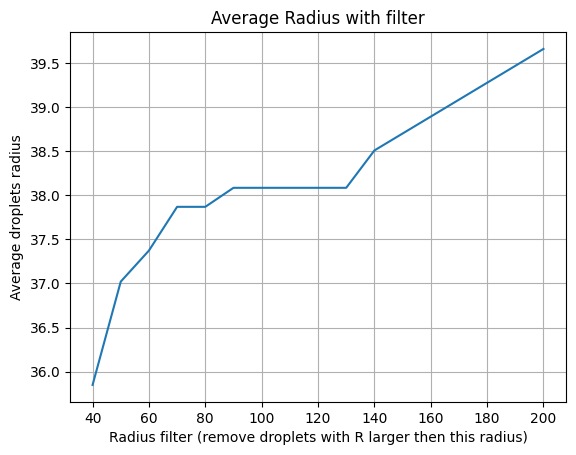

In [31]:


# extra thing
last_line_256 = d_vol256[-1];
last_line_256 = last_line_256[last_line_256 > 1]
ivanR = avg_e_tot_vol256[0,-1]
act_R = np.average(last_line_256)
print(act_R)
#print(last_line_256)
print("for last step:")
print("R all droplets = %f"%(ivanR))
Rs_fil = np.array([40,50,60,70,80,90,100,110,120,130,140,200])
Rs = []
for i in Rs_fil:
    Rs.append((ivanR/act_R)*np.average(last_line_256[last_line_256<i]))
    print("R (no droplets with R>%d )= %f"%(i,Rs[-1]))
Rs = np.array(Rs)
_ = plt.figure(100)
_ = plt.plot(Rs_fil, Rs)
_ = plt.xlabel('Radius filter (remove droplets with R larger then this radius)')
_ = plt.ylabel('Average droplets radius')
_ = plt.rc('axes', axisbelow=True)
#_ = plt.legend()
_ = plt.grid()
_ = plt.title('Average Radius with filter')

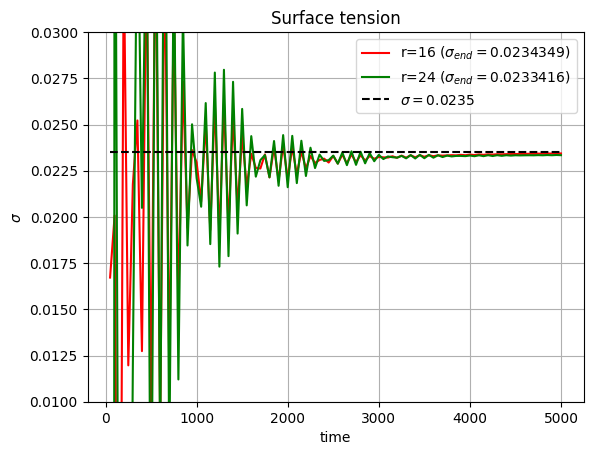

In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

def count_lines_in_file(file_path):
    with open(file_path, 'r') as file:
        line_count = sum(1 for _ in file)
    return line_count

# SURFACE TENSION

direc = "/home/matti/DATA/Mayonese/surf_tens/"
files = ["laplace_r8.dat", "laplace_r16.dat", "laplace_r24.dat"]

Nsteps = count_lines_in_file(direc+files[0])

sigma = np.zeros((4,Nsteps))
steps = np.zeros((Nsteps))
i = 0
for f in files:
    data = np.loadtxt(direc+f)
    sigma[i,:] = data[:,5]
    steps[:]   = data[:,0]
    i += 1

lw=1.5
_ = plt.figure(1000)
#_ = plt.plot(steps, sigma[0,:],color='blue', linewidth=lw, label=r'r=8 ($\sigma_{end}=%g$)'%sigma[0,-1])
_ = plt.plot(steps, sigma[1,:],color='red', linewidth=lw, label=r'r=16 ($\sigma_{end}=%g$)'%sigma[1,-1])
_ = plt.plot(steps, sigma[2,:],color='green', linewidth=lw, label=r'r=24 ($\sigma_{end}=%g$)'%sigma[2,-1])
sig = 0.0235
_ = plt.hlines(sig, np.min(steps), np.max(steps), color='black', linestyle='--', linewidth=lw, label=r'$\sigma=%g$'%sig)
_ = plt.xlabel('time')
_ = plt.ylabel(r'$\sigma$')
_ = plt.ylim([0.01,0.03])
_ = plt.title('Surface tension')
_ = plt.grid()
_ = plt.legend()

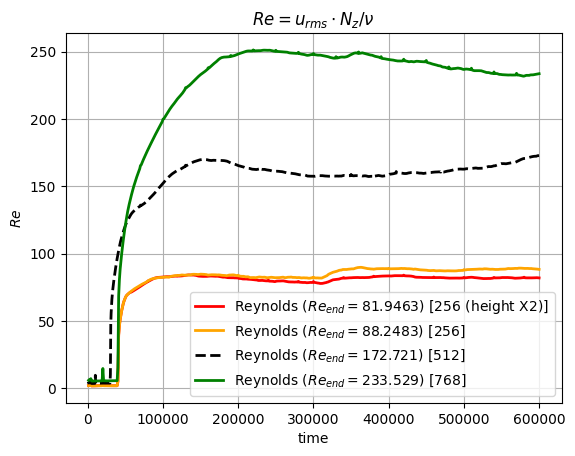

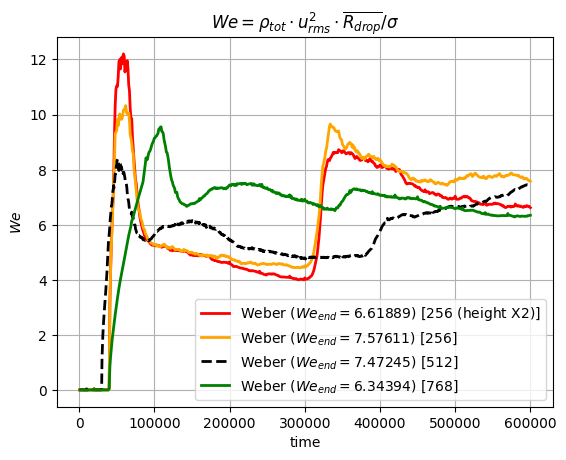

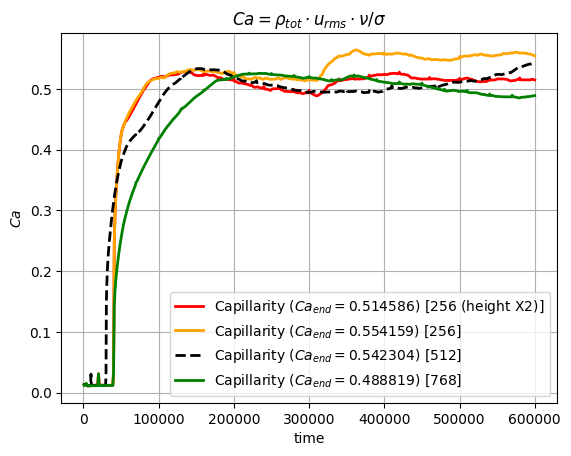

In [24]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

def count_lines_in_file(file_path):
    with open(file_path, 'r') as file:
        line_count = sum(1 for _ in file)
    return line_count

# DIMENSIONLESS NUMBERS

direc = "/home/matti/DATA/Mayonese/"
#files = ["staggered_run_halfZ/dimensionless_numbers256.csv", "staggered_run/dimensionless_numbers512.csv"]
files = ["staggered_run_halfZ_doubleX/dimensionless_numbers_256x1024.csv", 
         "staggered_run_halfZ/dimensionless_numbers256.csv",
         "staggered_run/dimensionless_numbers512.csv",
         "staggered_run_1.5Z/dimensionless_numbers768.csv"]
labs = ["256 (height X2)","256","512","768"]

Nsteps = [count_lines_in_file(direc+files[0]) - 1, count_lines_in_file(direc+files[1]) - 1, count_lines_in_file(direc+files[2]) - 1, count_lines_in_file(direc+files[3]) - 1]

dimless1 = np.zeros((6,Nsteps[0]))
dimless2 = np.zeros((6,Nsteps[1]))
dimless3 = np.zeros((6,Nsteps[2]))
dimless4 = np.zeros((6,Nsteps[3]))

data = np.loadtxt(direc+files[0], delimiter=',', skiprows=1)
dimless1[:,:] = data[:,:].T
data = np.loadtxt(direc+files[1], delimiter=',', skiprows=1)
dimless2[:,:] = data[:,:].T
data = np.loadtxt(direc+files[2], delimiter=',', skiprows=1)
dimless3[:,:] = data[:,:].T
data = np.loadtxt(direc+files[3], delimiter=',', skiprows=1)
dimless4[:,:] = data[:,:].T

lw=2
SAVE=1
save_dir = '/home/matti/Pictures/images/'

_ = plt.figure(1000)
_ = plt.plot(dimless1[0,:], dimless1[1,:], color='red', linewidth=lw, label=r'Reynolds ($Re_{end}=%g$) [%s]'%(dimless1[1,-1],labs[0]))
_ = plt.plot(dimless2[0,:], dimless2[1,:], color='orange', linewidth=lw, label=r'Reynolds ($Re_{end}=%g$) [%s]'%(dimless2[1,-1],labs[1]))
_ = plt.plot(dimless3[0,:], dimless3[1,:], color='black', linewidth=lw, linestyle='--', label=r'Reynolds ($Re_{end}=%g$) [%s]'%(dimless3[1,-1],labs[2]))
_ = plt.plot(dimless4[0,:], dimless4[1,:], color='green', linewidth=lw, label=r'Reynolds ($Re_{end}=%g$) [%s]'%(dimless4[1,-1],labs[3]))
_ = plt.xlabel('time')
_ = plt.ylabel(r'$Re$')
_ = plt.grid()
_ = plt.title(r"$Re = u_{rms}\cdot N_z / \nu$")
_ = plt.legend()
if SAVE:
    _ = plt.savefig(save_dir+"Re.png", bbox_inches='tight', dpi=300, format='png')

_ = plt.figure(1001)
_ = plt.plot(dimless1[0,:], dimless1[2,:], color='red', linewidth=lw, label=r'Weber ($We_{end}=%g$) [%s]'%(dimless1[2,-1],labs[0]))
_ = plt.plot(dimless2[0,:], dimless2[2,:], color='orange', linewidth=lw, label=r'Weber ($We_{end}=%g$) [%s]'%(dimless2[2,-1],labs[1]))
_ = plt.plot(dimless3[0,:], dimless3[2,:], color='black', linewidth=lw, linestyle='--', label=r'Weber ($We_{end}=%g$) [%s]'%(dimless3[2,-1],labs[2]))
_ = plt.plot(dimless4[0,:], dimless4[2,:], color='green', linewidth=lw, label=r'Weber ($We_{end}=%g$) [%s]'%(dimless4[2,-1],labs[3]))
_ = plt.xlabel('time')
_ = plt.ylabel(r'$We$')
_ = plt.grid()
_ = plt.title(r"$We = \rho_{tot} \cdot u^2_{rms}\cdot \overline{R_{drop}} / \sigma$")
_ = plt.legend()
if SAVE:
    _ = plt.savefig(save_dir+"We.png", bbox_inches='tight', dpi=300, format='png')

_ = plt.figure(1002)
_ = plt.plot(dimless1[0,:], dimless1[3,:], color='red', linewidth=lw, label=r'Capillarity ($Ca_{end}=%g$) [%s]'%(dimless1[3,-1],labs[0]))
_ = plt.plot(dimless2[0,:], dimless2[3,:], color='orange', linewidth=lw, label=r'Capillarity ($Ca_{end}=%g$) [%s]'%(dimless2[3,-1],labs[1]))
_ = plt.plot(dimless3[0,:], dimless3[3,:], color='black', linewidth=lw, linestyle='--', label=r'Capillarity ($Ca_{end}=%g$) [%s]'%(dimless3[3,-1],labs[2]))
_ = plt.plot(dimless4[0,:], dimless4[3,:], color='green', linewidth=lw, label=r'Capillarity ($Ca_{end}=%g$) [%s]'%(dimless4[3,-1],labs[3]))
_ = plt.xlabel('time')
_ = plt.ylabel(r'$Ca$')
_ = plt.grid()
_ = plt.title(r"$Ca = \rho_{tot} \cdot u_{rms}\cdot \nu / \sigma$")
_ = plt.legend()
if SAVE:
    _ = plt.savefig(save_dir+"Ca.png", bbox_inches='tight', dpi=300, format='png')

0.0006738130769496166 0.00016831249999999995


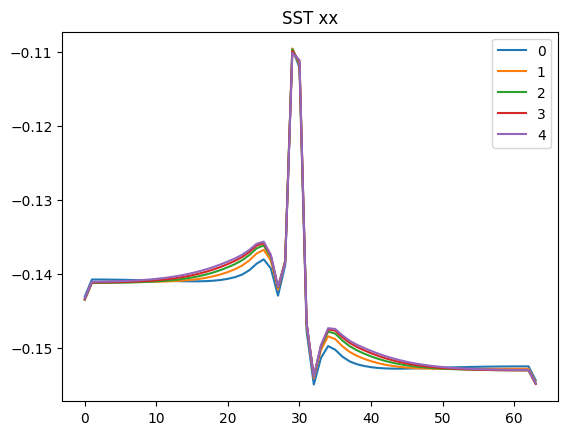

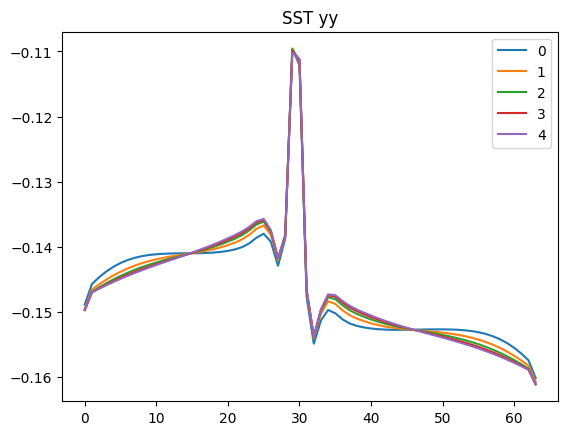

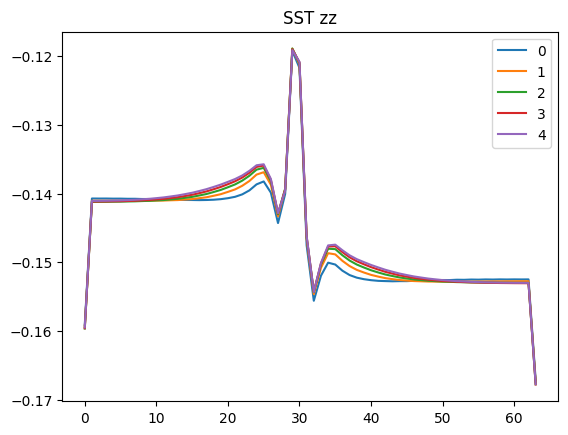

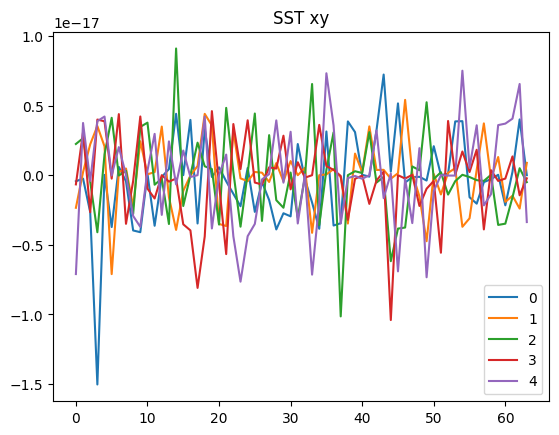

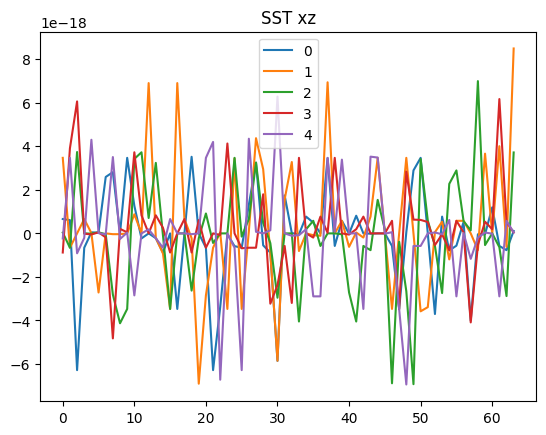

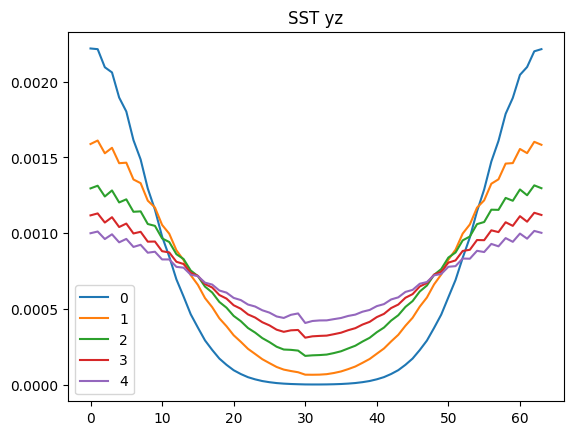

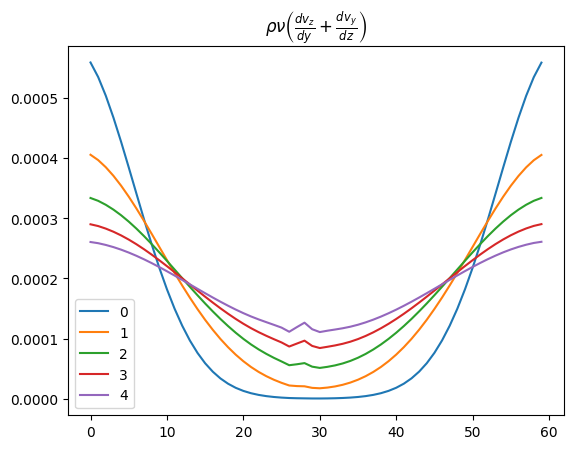

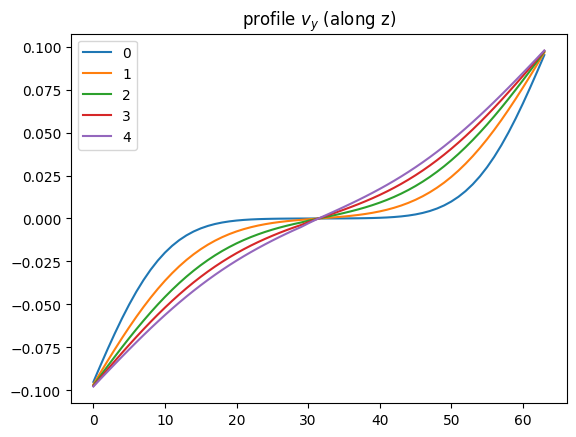

In [26]:
# SHEAR STRESS TENSOR TEST

import numpy as np
import matplotlib.pyplot as plt

def comp_nu(tau):
    return (tau-0.5)/3.0

rho1=0.18
rho2=0.18 #1.18
tau1=1
tau2=1
nu1=comp_nu(tau1)
nu2=comp_nu(tau2)

direc = "/home/matti/programming/lbe-direct/src/tests/"

direc += "SCMP_POISEUILLE_SHEARSTRESSTENSOR/"
#direc += "P01_couette_SHEARSTRESSTENSOR/"

with open(direc+"sst_xx.dat", 'r') as f:
    SSTxx = np.loadtxt(f)
with open(direc+"sst_xy.dat", 'r') as f:
    SSTxy = np.loadtxt(f)
with open(direc+"sst_xz.dat", 'r') as f:
    SSTxz = np.loadtxt(f)
with open(direc+"sst_yy.dat", 'r') as f:
    SSTyy = np.loadtxt(f)
with open(direc+"sst_yz.dat", 'r') as f:
    SSTyz = np.loadtxt(f)
with open(direc+"sst_zz.dat", 'r') as f:
    SSTzz = np.loadtxt(f)
with open(direc+"grad_v_sum.dat", 'r') as f:
    gradvsum = np.loadtxt(f) * (rho1*nu1+rho2*nu2)
with open(direc+"vy_along_z.dat", 'r') as f:
    vy = np.loadtxt(f)

def ppp(i, f, name):
    plt.figure(i)
    N = len(f[:,0])
    for j in range(N):
        plt.plot(f[j,:], label="%d"%j)
    plt.title(name)
    plt.legend()

ppp(1, SSTxx, "SST xx")
ppp(2, SSTyy, "SST yy")
ppp(3, SSTzz, "SST zz")
ppp(4, SSTxy, "SST xy")
ppp(5, SSTxz, "SST xz")
ppp(6, SSTyz, "SST yz")
print(SSTyz[-1,16], gradvsum[-1,16])
ppp(7,  gradvsum, r"$\rho\nu\left(\frac{dv_z}{dy}+\frac{dv_y}{dz}\right)$")
ppp(8,  vy,   r"profile $v_y$ (along z)")